In [1]:
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import accuracy_score
import numpy as np
import random
from itertools import product
import time
from sklearn.metrics import accuracy_score, f1_score
from matplotlib import pyplot as plt

In [2]:
SEED = 67

def set_seed(seed=SEED):
    # Python built-in random
    random.seed(seed)
    
    # NumPy
    np.random.seed(seed)
    
    # PyTorch CPU
    torch.manual_seed(seed)
    
    # PyTorch GPU (if available)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    # Ensure deterministic behavior in CuDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Call this at the very beginning
set_seed()

In [3]:
train_df = pd.read_csv("dataset/data/processed/train_split.csv")
val_df = pd.read_csv("dataset/data/processed/val_split.csv")
test_df = pd.read_csv("dataset/data/processed/test_split.csv")

X_train = train_df.drop(columns=["Label"]).values
y_train = train_df["Label"].values

X_val   = val_df.drop(columns=["Label"]).values
y_val   = val_df["Label"].values

X_test  = test_df.drop(columns=["Label"]).values
y_test  = test_df["Label"].values

In [4]:
print("Shapes:")
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)

Shapes:
Train: (3000, 140)
Val: (1000, 140)
Test: (1000, 140)


In [4]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        # Convert numpy arrays to PyTorch tensors
        # unsqueeze(1): add a channel dimension (for CNN input)
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = ECGDataset(X_train, y_train)
val_dataset   = ECGDataset(X_val, y_val)
test_dataset  = ECGDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)
test_loader  = DataLoader(test_dataset, batch_size=32)

In [5]:
class CNN1D_Baseline(nn.Module):
    def __init__(self, hidden_size=32, kernel_size=5, dropout=0.3, num_classes=5, activation='relu'):
        super(CNN1D_Baseline, self).__init__()

        # choose activation
        if activation.lower() == 'relu':
            act_fn = nn.ReLU()
        elif activation.lower() == 'tanh':
            act_fn = nn.Tanh()
        elif activation.lower() == 'gelu':
            act_fn = nn.GELU()
        elif activation.lower() == 'leakyrelu':
            act_fn = nn.LeakyReLU()
        else:
            raise ValueError(f"Unknown activation {activation}")

        self.conv_block = nn.Sequential(
            nn.Conv1d(1, hidden_size, kernel_size, padding=kernel_size//2),
            act_fn,
            nn.MaxPool1d(2),
            nn.Conv1d(hidden_size, hidden_size*2, kernel_size, padding=kernel_size//2),
            act_fn,
            nn.MaxPool1d(2)
        )

        self.flattened_size = (hidden_size*2) * (140 // 4)  # adjust based on your input length

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flattened_size, 128),
            act_fn,
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x


In [6]:
#Hyperparameters
batch_size = 64
hidden_size = 32       # this will control CNN filters
lr = 1e-3
num_epochs = 10
output_size = 5


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
model = CNN1D_Baseline(
    hidden_size=hidden_size,
    dropout=0.3,
    num_classes=output_size
).to(device)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [9]:
import pandas as pd
import time

results = []

start_time = time.time()
for epoch in range(num_epochs):
    set_seed()
    
    # --- Training ---
    model.train()
    running_loss = 0.0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X.size(0)
    
    # --- Validation ---
    model.eval()
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)  # we don’t need val metrics if not saving
    
    # --- Test ---
    test_loss = 0.0
    all_test_preds, all_test_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            preds = torch.argmax(logits, dim=1)
            all_test_preds.append(preds.cpu())
            all_test_labels.append(y.cpu())
    all_test_preds = torch.cat(all_test_preds)
    all_test_labels = torch.cat(all_test_labels)
    test_acc = accuracy_score(all_test_labels, all_test_preds)
    test_f1  = f1_score(all_test_labels, all_test_preds, average='macro')
    
    print(f"Epoch {epoch}/{num_epochs} | "
            f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

training_time = time.time() - start_time

# --- Save metrics to CSV ---
results.append({
    'train_time_s': round(training_time, 2),
    'test_acc': round(test_acc, 4),
    'test_f1': round(test_f1, 4)
})

results_df = pd.DataFrame(results)
results_df.to_csv("torch_logs/cnn_results.csv", index=False)

print(f"Training time: {training_time:.2f} s | Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")


Epoch 0/10 | Test Acc: 0.9370 | Test F1: 0.4773
Epoch 1/10 | Test Acc: 0.9450 | Test F1: 0.5403
Epoch 2/10 | Test Acc: 0.9480 | Test F1: 0.5759
Epoch 3/10 | Test Acc: 0.9530 | Test F1: 0.5938
Epoch 4/10 | Test Acc: 0.9550 | Test F1: 0.6019
Epoch 5/10 | Test Acc: 0.9550 | Test F1: 0.6019
Epoch 6/10 | Test Acc: 0.9540 | Test F1: 0.5973
Epoch 7/10 | Test Acc: 0.9550 | Test F1: 0.6071
Epoch 8/10 | Test Acc: 0.9540 | Test F1: 0.6038
Epoch 9/10 | Test Acc: 0.9540 | Test F1: 0.6038
Training time: 13.99 s | Test Acc: 0.9540 | Test F1: 0.6038


In [9]:
grid_params = {
    'hidden_size': [16, 24, 32, 48, 64, 96],
    'lr': [0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01],
    'activation': ['relu'],
    'optimizer_name': ['adam'],
    'dropout': [0.2],
    'weight_init': ['default']
}

In [11]:
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_combinations = list(product(grid_params['hidden_size'], grid_params['lr']))

for hidden_size, lr in all_combinations:
    set_seed()
    print(f"\n=== Experiment: hidden_size={hidden_size}, lr={lr} ===")

    # Initialize model
    model = CNN1D_Baseline(hidden_size=hidden_size, dropout=0.2, num_classes=output_size).to(device)

    # Loss + optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    start_time = time.time()
    
    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                preds = torch.argmax(logits, dim=1)
                all_val_preds.append(preds.cpu())
                all_val_labels.append(y.cpu())
        val_acc = accuracy_score(torch.cat(all_val_labels), torch.cat(all_val_preds))
        val_f1  = f1_score(torch.cat(all_val_labels), torch.cat(all_val_preds), average='macro')

        # --- Test ---
        all_test_preds, all_test_labels = [], []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                preds = torch.argmax(logits, dim=1)
                all_test_preds.append(preds.cpu())
                all_test_labels.append(y.cpu())
        test_acc = accuracy_score(torch.cat(all_test_labels), torch.cat(all_test_preds))
        test_f1  = f1_score(torch.cat(all_test_labels), torch.cat(all_test_preds), average='macro')

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

    # --- Save only final metrics for CSV ---
    training_time = time.time() - start_time
    results.append({
        'hidden_size': hidden_size,
        'lr': lr,
        'train_time_s': round(training_time, 2),
        'test_acc': round(test_acc, 4),
        'test_f1': round(test_f1, 4)
    })

# Convert to DataFrame and save CSV
results_df = pd.DataFrame(results)
results_df.to_csv("torch_logs/cnn_grid_search_all_models.csv", index=False)



=== Experiment: hidden_size=16, lr=5e-05 ===
Epoch 1/10 | Test Acc: 0.8870 | Test F1: 0.3636
Epoch 2/10 | Test Acc: 0.9170 | Test F1: 0.3763
Epoch 3/10 | Test Acc: 0.9230 | Test F1: 0.3785
Epoch 4/10 | Test Acc: 0.9310 | Test F1: 0.3819
Epoch 5/10 | Test Acc: 0.9330 | Test F1: 0.3826
Epoch 6/10 | Test Acc: 0.9330 | Test F1: 0.4012
Epoch 7/10 | Test Acc: 0.9320 | Test F1: 0.4004
Epoch 8/10 | Test Acc: 0.9380 | Test F1: 0.4410
Epoch 9/10 | Test Acc: 0.9390 | Test F1: 0.4481
Epoch 10/10 | Test Acc: 0.9370 | Test F1: 0.4328

=== Experiment: hidden_size=16, lr=0.0001 ===
Epoch 1/10 | Test Acc: 0.9150 | Test F1: 0.3758
Epoch 2/10 | Test Acc: 0.9270 | Test F1: 0.3799
Epoch 3/10 | Test Acc: 0.9340 | Test F1: 0.3828
Epoch 4/10 | Test Acc: 0.9410 | Test F1: 0.4718
Epoch 5/10 | Test Acc: 0.9380 | Test F1: 0.4477
Epoch 6/10 | Test Acc: 0.9430 | Test F1: 0.4764
Epoch 7/10 | Test Acc: 0.9400 | Test F1: 0.4429
Epoch 8/10 | Test Acc: 0.9440 | Test F1: 0.4945


KeyboardInterrupt: 

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your CNN grid search file
df = pd.read_csv("torch_logs/cnn_grid_search_all_models.csv")

metrics = {
    "test_acc": "YlGnBu",
    "test_f1": "RdPu",
    "train_time_s": "Oranges"
}
def plots(p1, p2):
    sns.set_theme(style="white")
    sns.set(font_scale=1.6)  # BIG captions
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 9), dpi=200)  # BIGGER + SHARPER

    for ax, (metric, cmap) in zip(axes, metrics.items()):
        pivot = df.pivot_table(values=metric, index=p1, columns=p2, aggfunc="mean")

        # Draw heatmap with **thicker lines** and **bigger annotation text**
        sns.heatmap(
            pivot,
            annot=True,
            fmt=".3f",
            cmap=cmap,
            ax=ax,
            annot_kws={"size": 16, "weight": "bold"},  # 👈 very clear numbers
            linewidths=1.5,  # 👈 thick grid lines, reduces blur
            linecolor="black",
            cbar_kws={"shrink": 0.6}
        )

        ax.set_title(f"{metric} — {p1} vs {p2}", fontsize=20, pad=12)
        ax.set_xlabel(p2, fontsize=16)
        ax.set_ylabel(p1, fontsize=16)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=14)

    plt.tight_layout()
    plt.show()


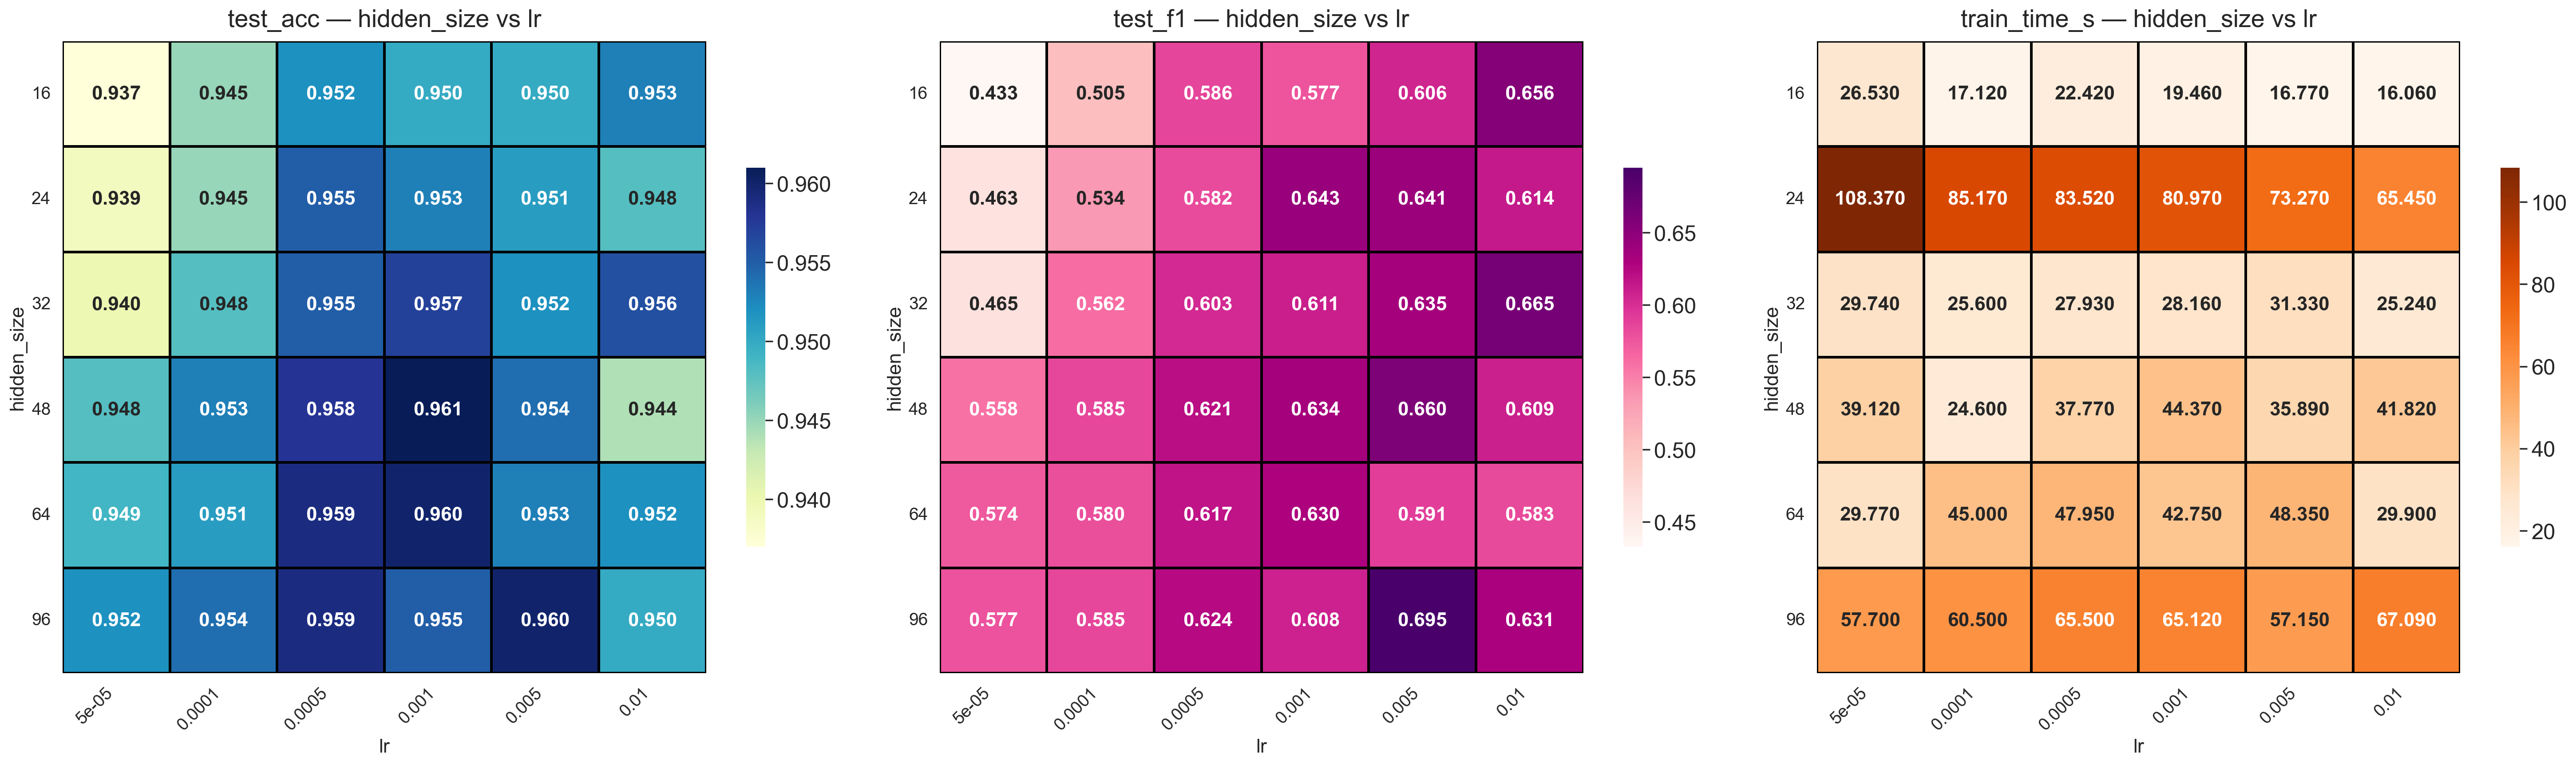

In [29]:
plots("hidden_size", "lr")

In [14]:
grid_params = {
    'hidden_size': [48],
    'lr': [0.001],
    'activation': ['relu', 'tanh', 'gelu', 'leakyrelu'],
    'optimizer_name': ['adagrad', 'adamw', 'nadam', 'sgd', 'adam', 'rmsprop'],
    'dropout':  [0.0, 0.1, 0.2, 0.3],
    'weight_init': ['default', 'xavier', 'kaiming', 'orthogonal']
}

In [15]:
results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_combinations = list(product(grid_params['activation'], grid_params['optimizer_name'],
                                grid_params['dropout'], grid_params['weight_init']))

for activation, optimizer_name, dropout, weight_init in all_combinations:
    set_seed()
    print(f"\n=== Experiment: activation={activation}, optimizer_name={optimizer_name}, dropout={dropout}, weight_init={weight_init} ===")

    # Initialize model
    output_size = 5
    model = CNN1D_Baseline(hidden_size=48, dropout=dropout, num_classes=output_size, activation=activation).to(device)

    def init_weights(model, init_type='default'):
        for name, param in model.named_parameters():
            if 'weight' in name:
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(param)
                elif init_type == 'kaiming':
                    nn.init.kaiming_uniform_(param, nonlinearity='relu')
                elif init_type == 'orthogonal':
                    nn.init.orthogonal_(param)


    if weight_init != 'default':
        init_weights(model, weight_init)

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_name.lower() == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
    elif optimizer_name.lower() == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    elif optimizer_name.lower() == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=0.001)
    elif optimizer_name.lower() == 'nadam':
        optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)

    # Loss + optimizer
    criterion = nn.CrossEntropyLoss()

    start_time = time.time()
    
    for epoch in range(1, num_epochs + 1):
        # --- Training ---
        model.train()
        running_loss = 0.0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X.size(0)
        train_loss = running_loss / len(train_loader.dataset)

        # --- Validation ---
        model.eval()
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                preds = torch.argmax(logits, dim=1)
                all_val_preds.append(preds.cpu())
                all_val_labels.append(y.cpu())
        val_acc = accuracy_score(torch.cat(all_val_labels), torch.cat(all_val_preds))
        val_f1  = f1_score(torch.cat(all_val_labels), torch.cat(all_val_preds), average='macro')

        # --- Test ---
        all_test_preds, all_test_labels = [], []
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                logits = model(X)
                preds = torch.argmax(logits, dim=1)
                all_test_preds.append(preds.cpu())
                all_test_labels.append(y.cpu())
        test_acc = accuracy_score(torch.cat(all_test_labels), torch.cat(all_test_preds))
        test_f1  = f1_score(torch.cat(all_test_labels), torch.cat(all_test_preds), average='macro')

        print(f"Epoch {epoch}/{num_epochs} | "
              f"Test Acc: {test_acc:.4f} | Test F1: {test_f1:.4f}")

    # --- Save only final metrics for CSV ---
    training_time = time.time() - start_time
    results.append({
    'activation': activation,
    'optimizer': optimizer_name,
    'dropout': dropout,
    'weight_init': weight_init,
    'train_time_s': round(training_time, 2),
    'test_acc': round(test_acc, 4),
    'test_f1': round(test_f1, 4)
    })

# Convert to DataFrame and save CSV
results_df = pd.DataFrame(results)
results_df.to_csv("torch_logs/cnn_grid_search_all_models2.csv", index=False)



=== Experiment: activation=relu, optimizer_name=adagrad, dropout=0.0, weight_init=default ===
Epoch 1/10 | Test Acc: 0.9340 | Test F1: 0.3827
Epoch 2/10 | Test Acc: 0.9390 | Test F1: 0.4360
Epoch 3/10 | Test Acc: 0.9430 | Test F1: 0.5010
Epoch 4/10 | Test Acc: 0.9420 | Test F1: 0.4927
Epoch 5/10 | Test Acc: 0.9420 | Test F1: 0.4826
Epoch 6/10 | Test Acc: 0.9450 | Test F1: 0.5180
Epoch 7/10 | Test Acc: 0.9460 | Test F1: 0.5157
Epoch 8/10 | Test Acc: 0.9490 | Test F1: 0.5580
Epoch 9/10 | Test Acc: 0.9500 | Test F1: 0.5743
Epoch 10/10 | Test Acc: 0.9510 | Test F1: 0.5770

=== Experiment: activation=relu, optimizer_name=adagrad, dropout=0.0, weight_init=xavier ===
Epoch 1/10 | Test Acc: 0.9390 | Test F1: 0.4680
Epoch 2/10 | Test Acc: 0.9400 | Test F1: 0.4426
Epoch 3/10 | Test Acc: 0.9400 | Test F1: 0.4506
Epoch 4/10 | Test Acc: 0.9400 | Test F1: 0.4589
Epoch 5/10 | Test Acc: 0.9460 | Test F1: 0.5497
Epoch 6/10 | Test Acc: 0.9440 | Test F1: 0.5186
Epoch 7/10 | Test Acc: 0.9490 | Test F1: 0

In [31]:
df = pd.read_csv("torch_logs/cnn_grid_search_all_models2.csv")

metrics = {
    "test_acc": "YlGnBu",
    "test_f1": "RdPu",
    "train_time_s": "Oranges"
}

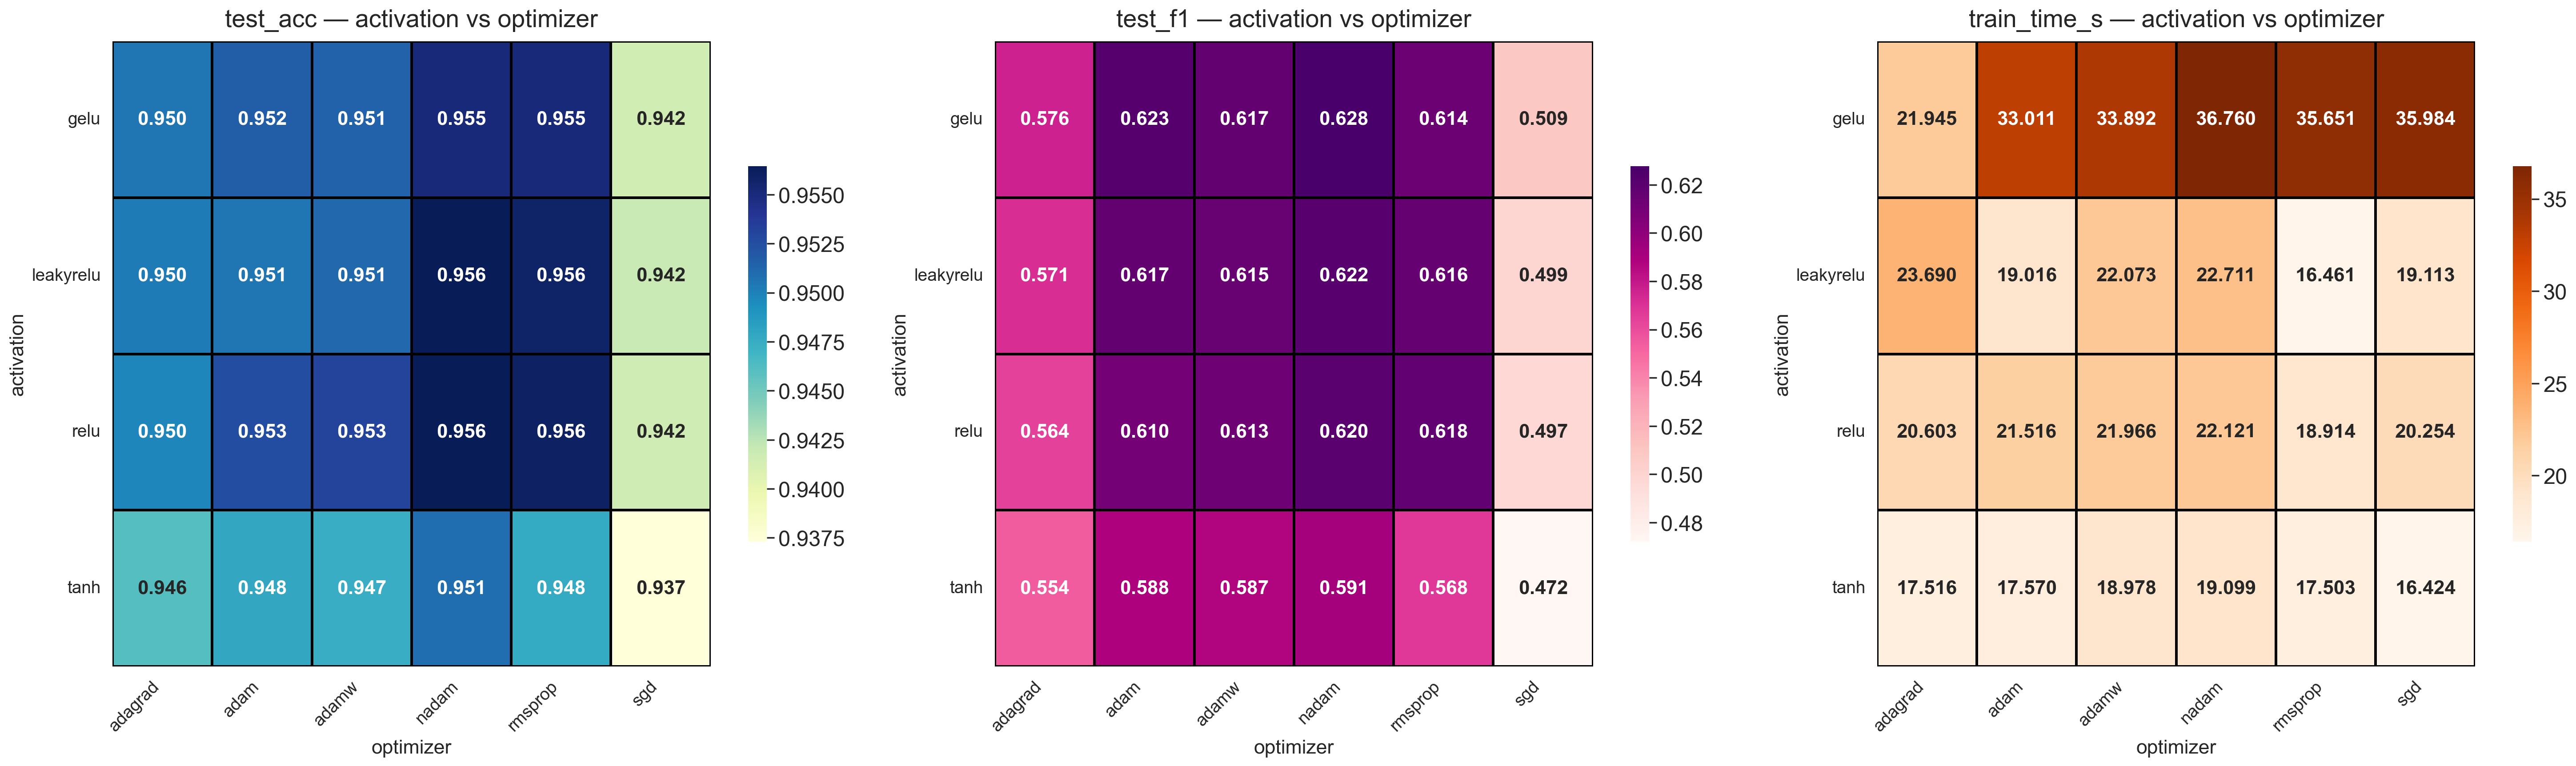

In [32]:
plots("activation", "optimizer")

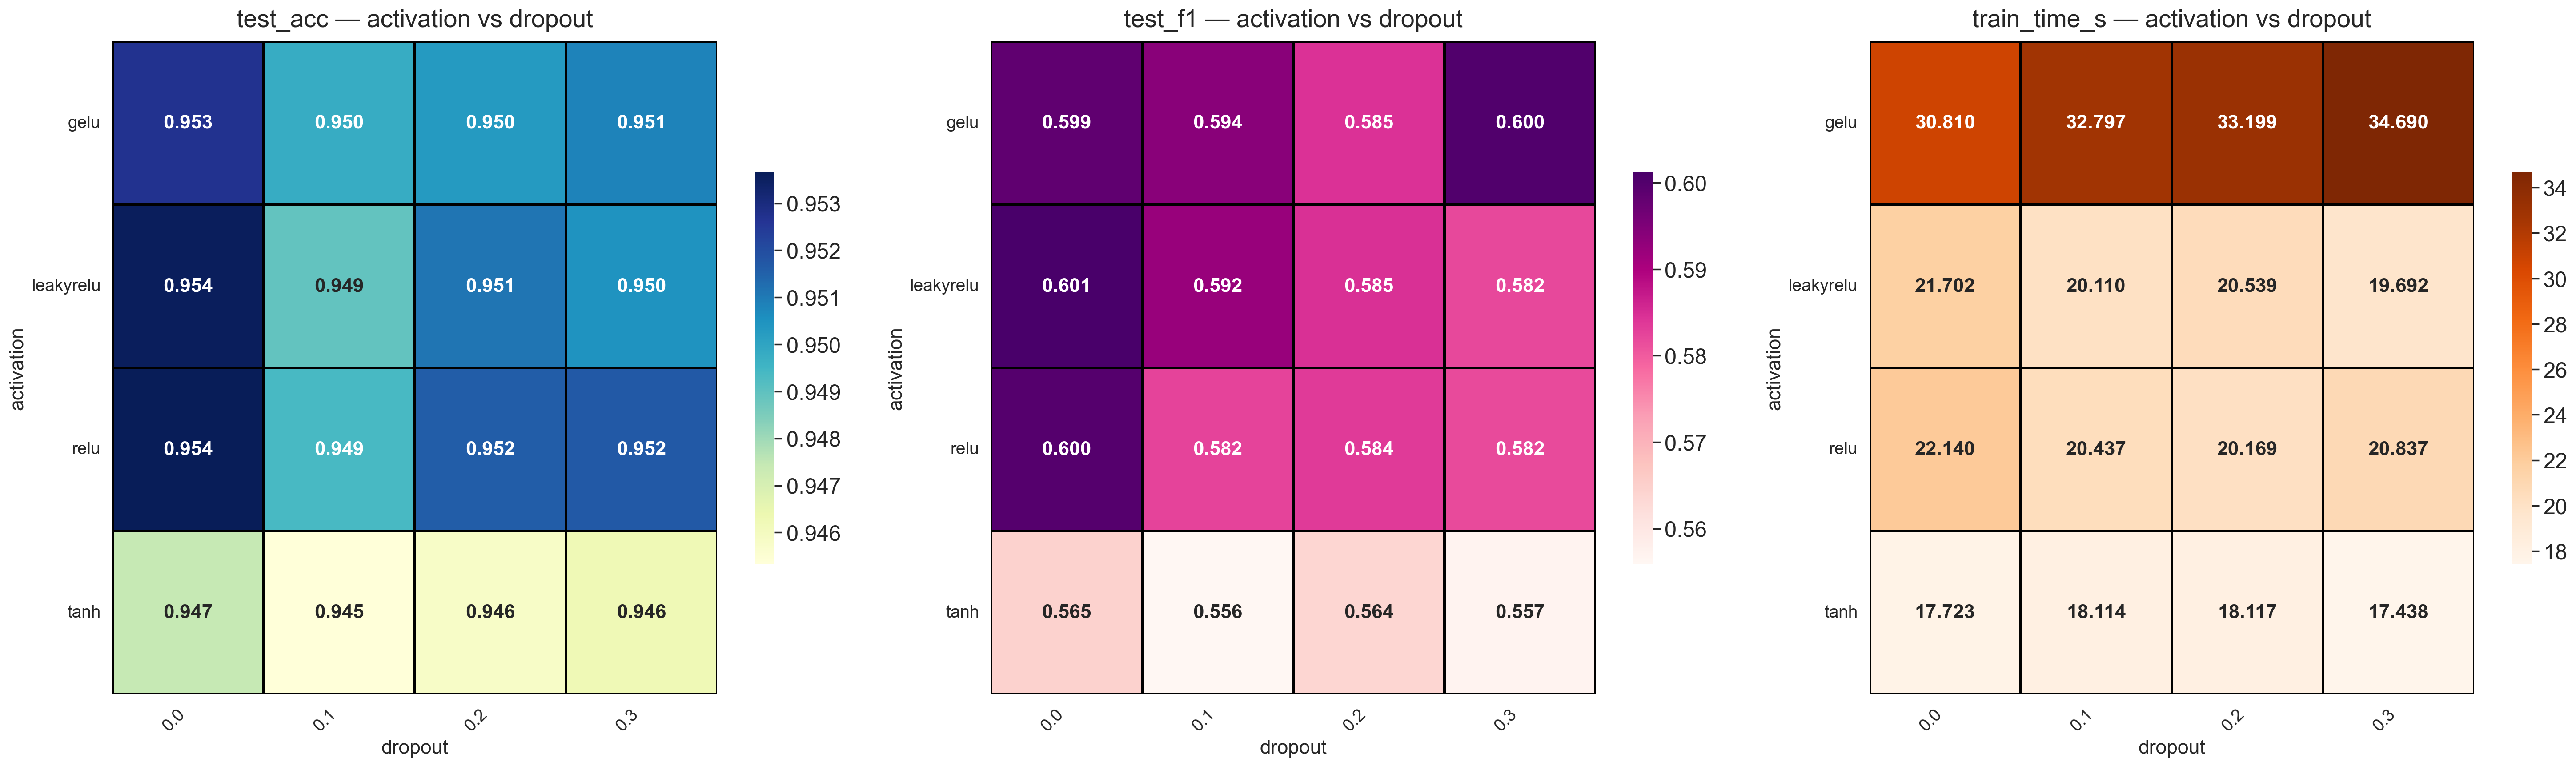

In [36]:
plots("activation", "dropout")

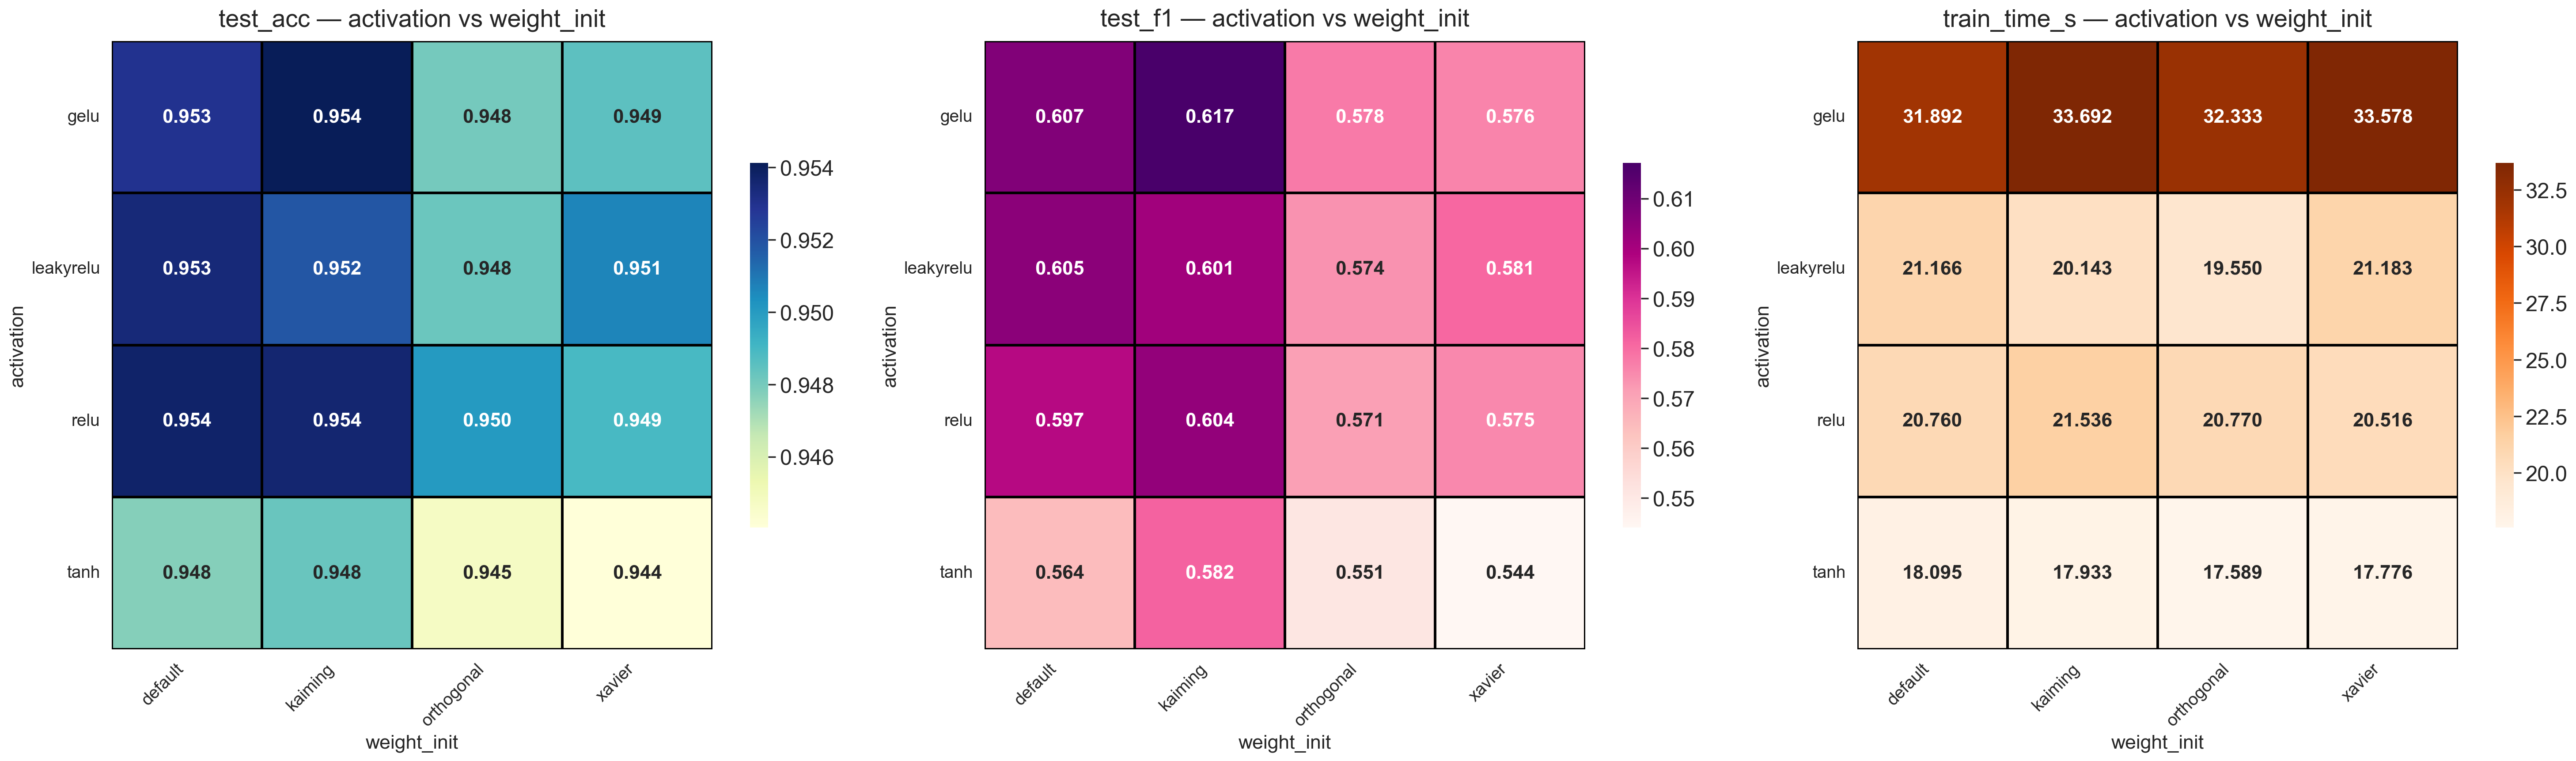

In [37]:
plots("activation", "weight_init")

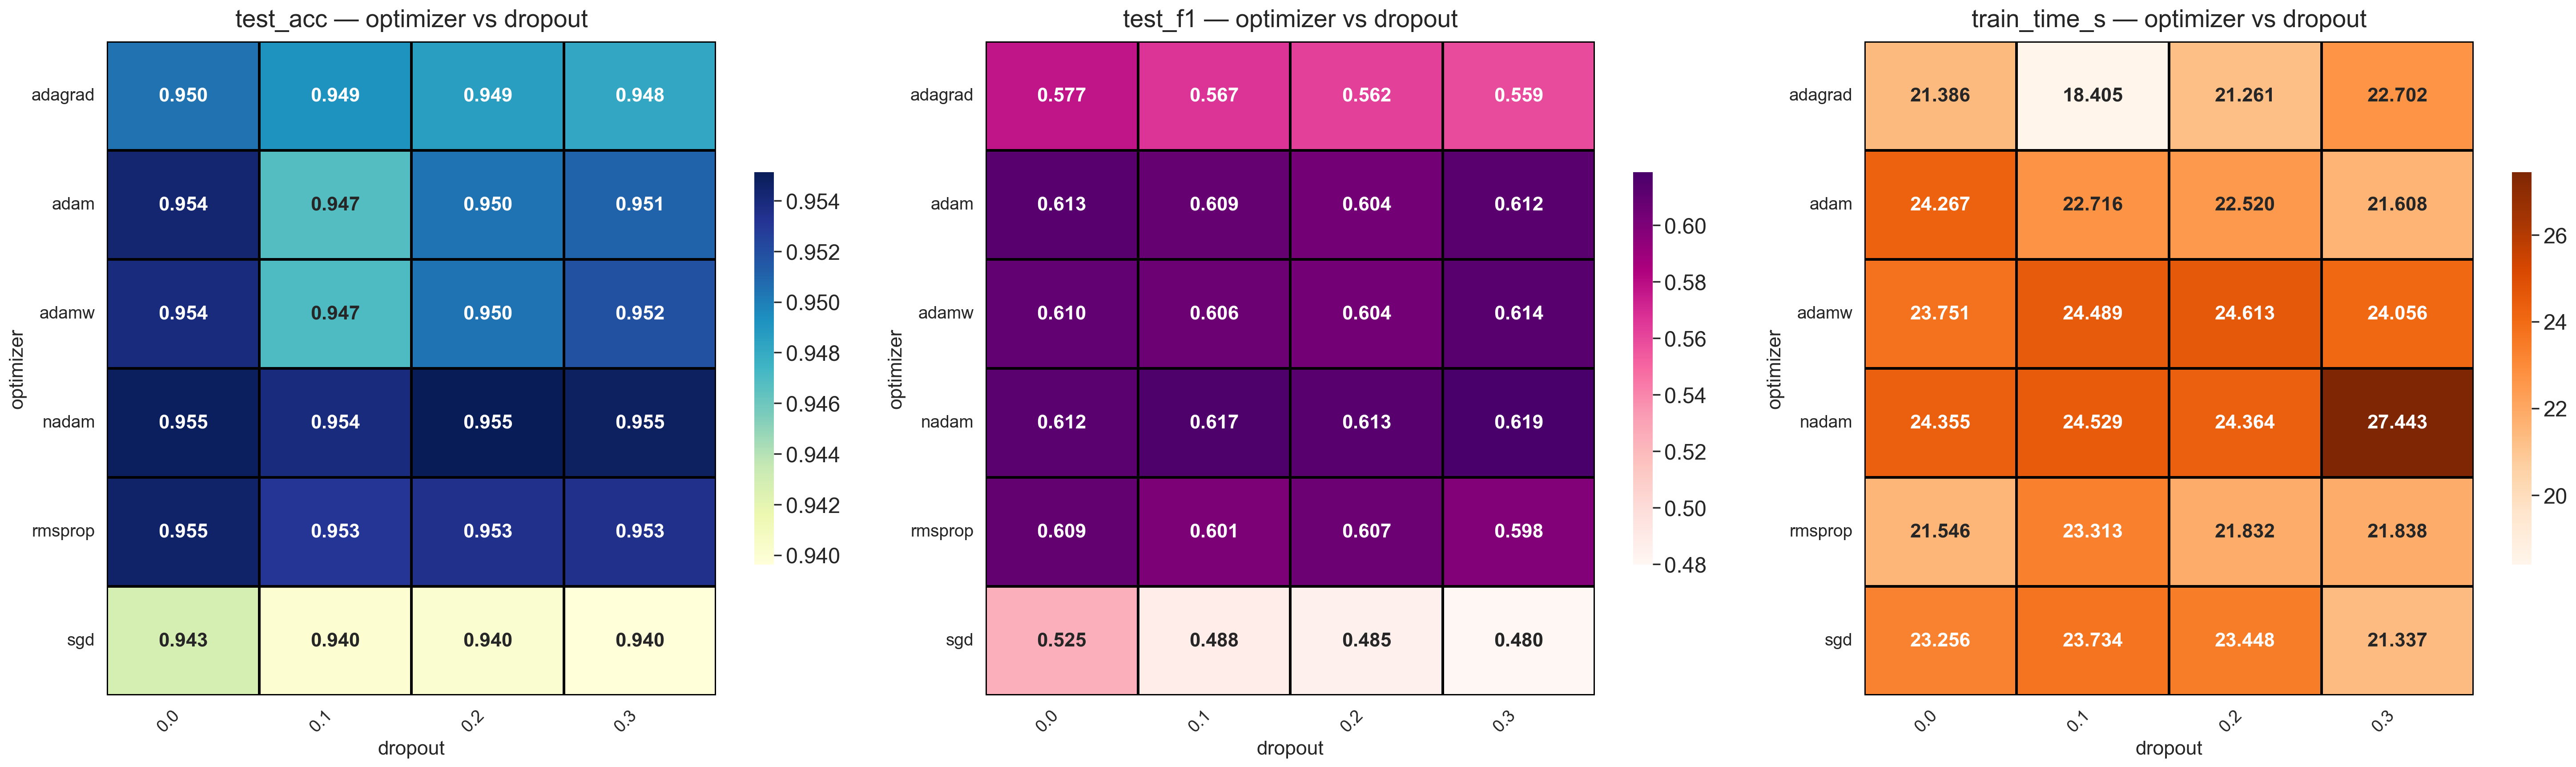

In [38]:
plots("optimizer", "dropout")

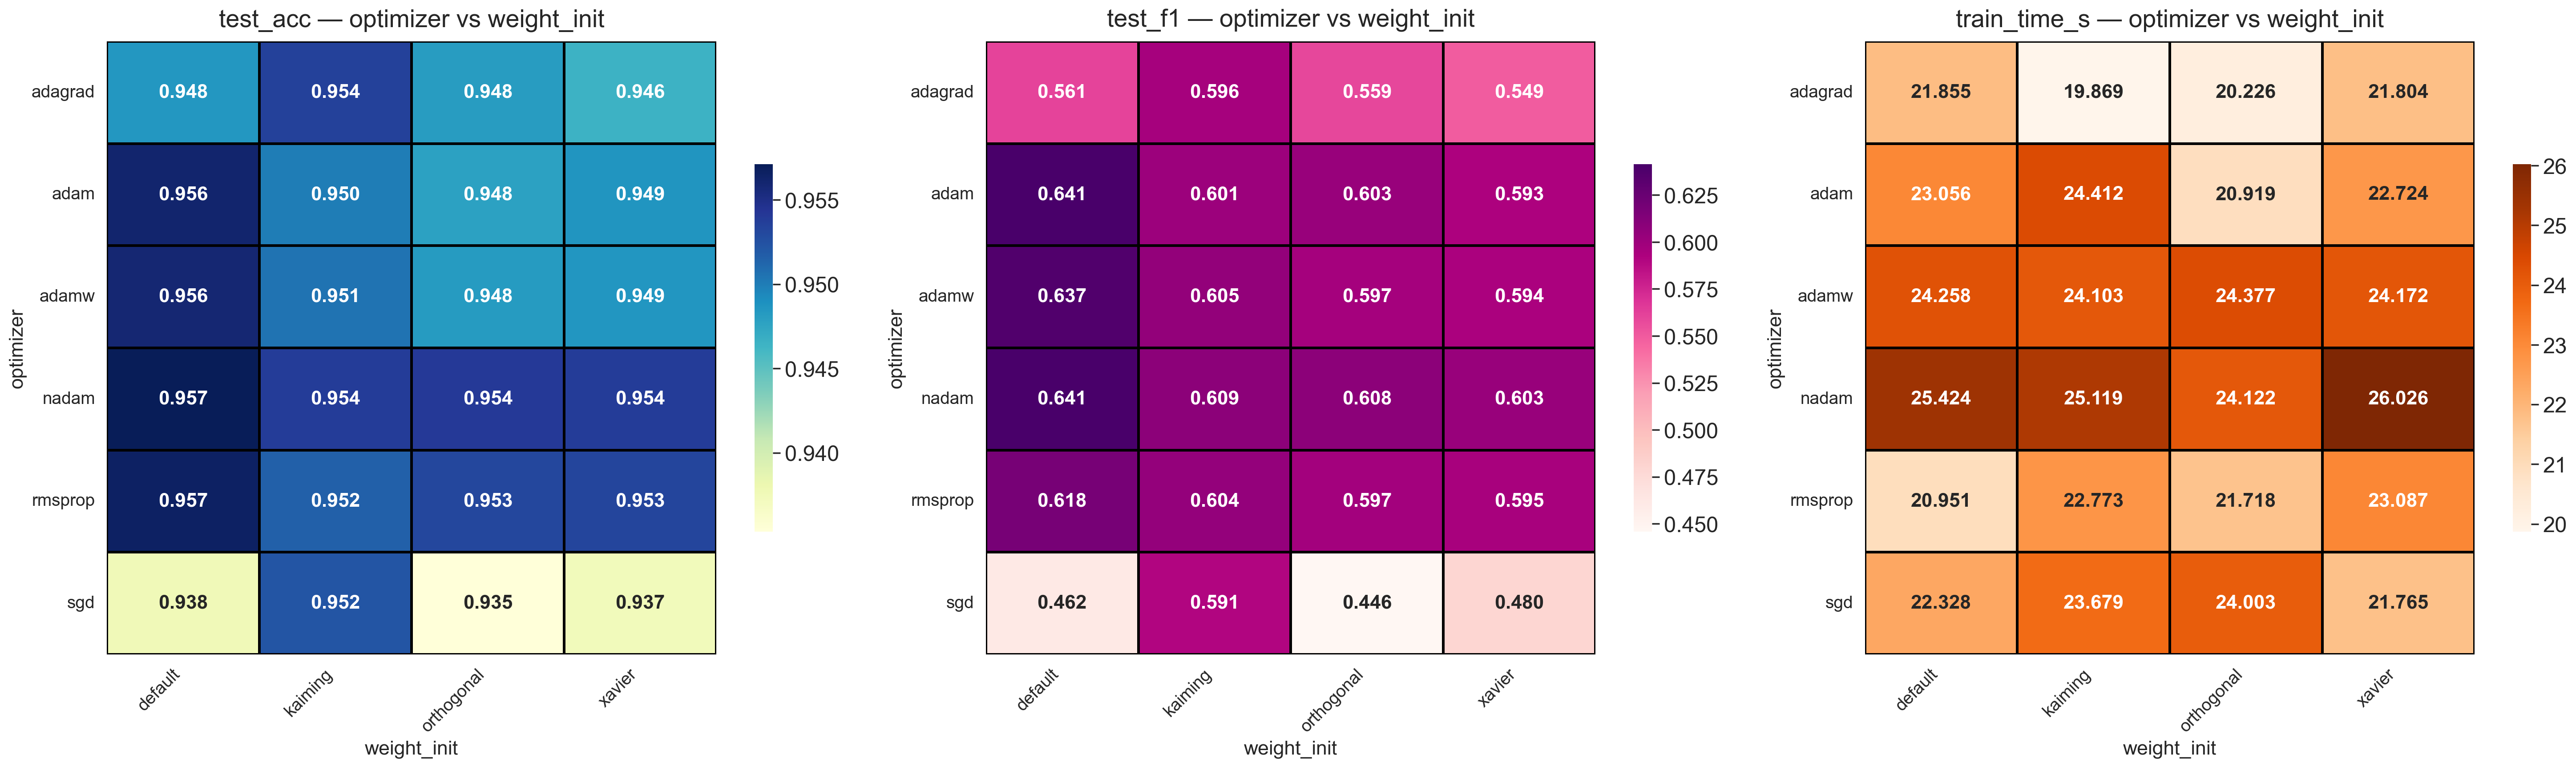

In [39]:
plots("optimizer", "weight_init")

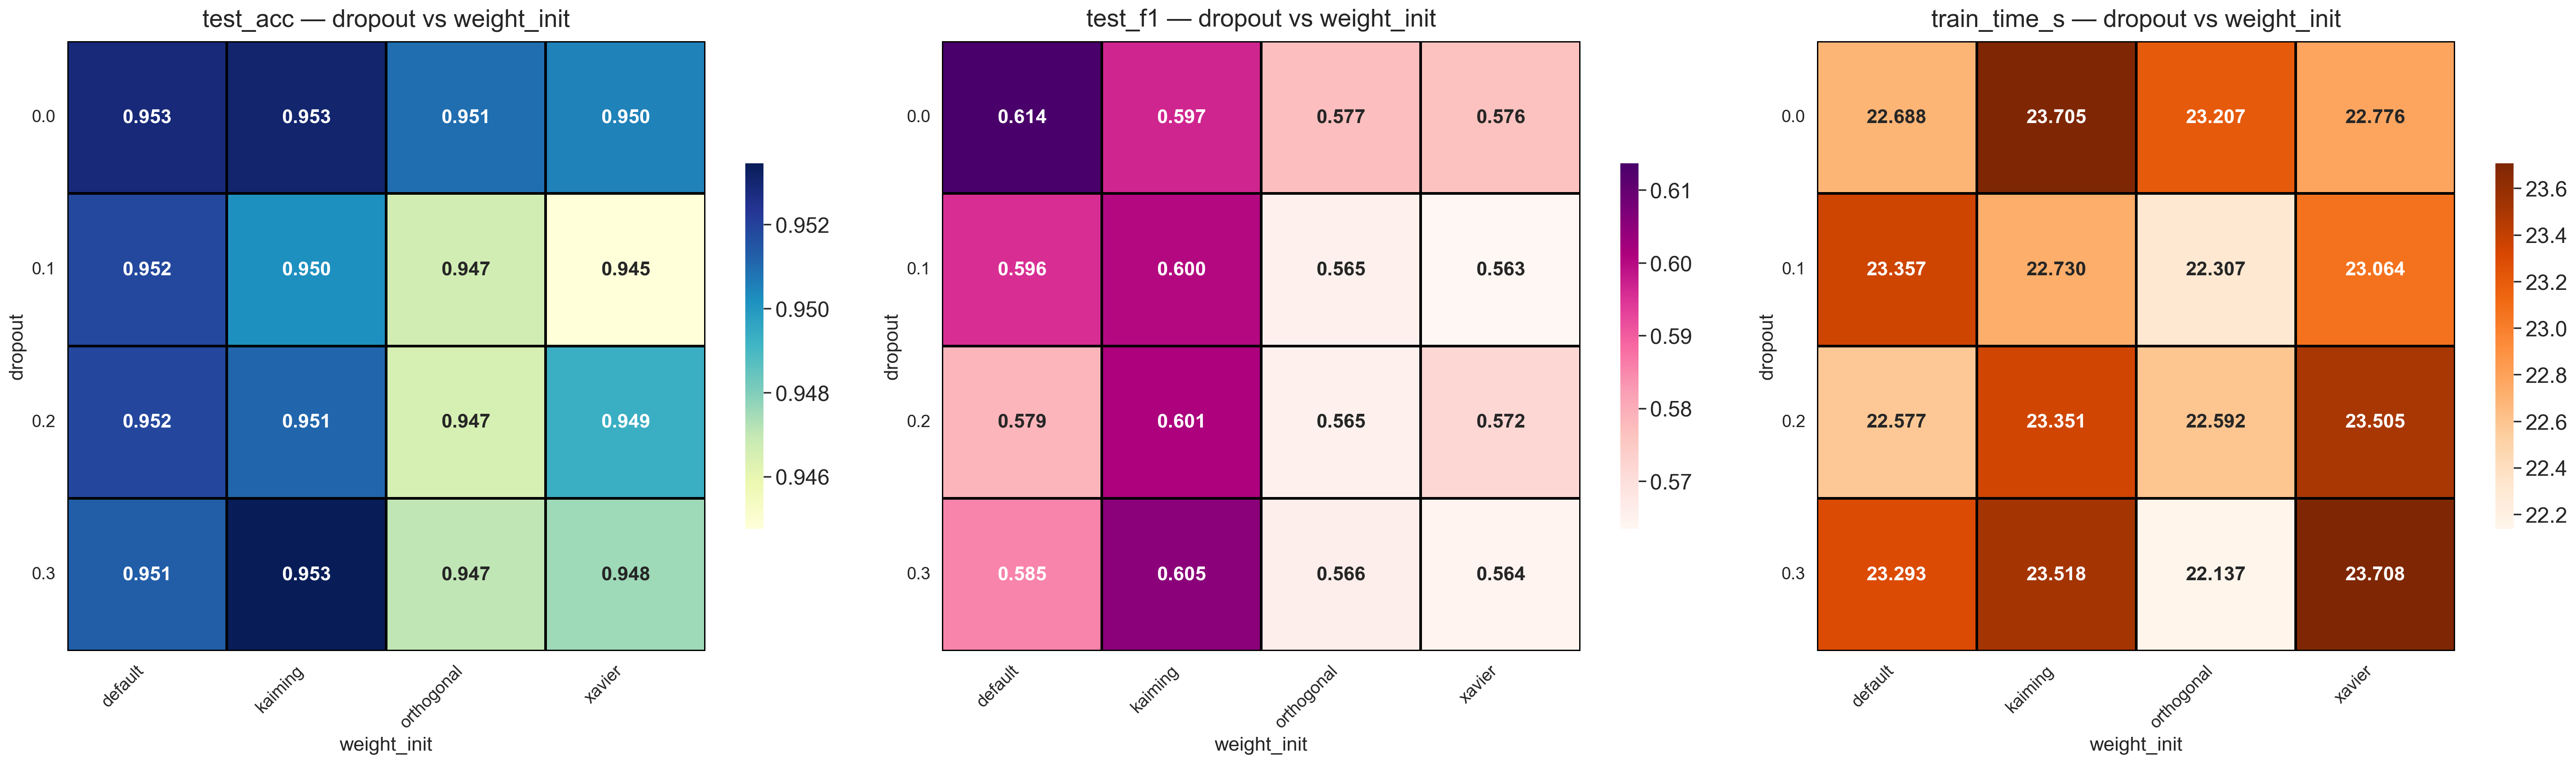

In [40]:
plots("dropout", "weight_init")